In [17]:
import requests
import json
import pandas as pd
import os
import re
import time
from tqdm import tqdm
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from collections import Counter

In [8]:
# --- Constants ---
SKIP_TYPES = {"Half End", "Half Start", "Referee Ball Drop", "Starting XI"}

# --- Helpers ---
def safe_key(s: str) -> str:
    return re.sub(r"\W+", "_", (s or "").strip())

def parse_match_id_from_filename(path: str) -> str:
    m = re.search(r"_([0-9]+)\.json$", os.path.basename(path))
    return m.group(1) if m else "unknown"

# --- Core logic (updated to also track players) ---
def build_team_sequences(events):
    """
    Collects sequences of type.name for each team, split by team switches,
    and also collects the corresponding player names in the same order.
    Returns:
      sequences: { team_id: [ {"words":[...], "players":[...]}, ... ] }
      id_to_name: { team_id: team_name }
    """
    id_to_name = {}
    sequences = {}
    current_team = None
    buffer_words = []
    buffer_players = []

    for ev in events:
        team = ev.get("team") or {}
        team_id = team.get("id")
        team_name = team.get("name")
        if team_id is None or team_name is None:
            continue

        id_to_name[team_id] = team_name

        t = ev.get("type")
        tname = t.get("name") if isinstance(t, dict) else None
        # Normalize "Ball Receipt*"
        if tname == "Ball Receipt*":
            tname = "Ball Receipt"

        # Skip unwanted event types
        if tname in SKIP_TYPES or tname is None:
            continue

        # Player name (align one-to-one with the event in words)
        player_name = (ev.get("player") or {}).get("name") or "Unknown"

        if current_team is None:
            # First seen team
            current_team = team_id
            buffer_words.append(tname)
            buffer_players.append(player_name)
            continue

        if team_id == current_team:
            # Same team → keep accumulating
            buffer_words.append(tname)
            buffer_players.append(player_name)
        else:
            # Team switch → flush previous run
            if buffer_words:
                sequences.setdefault(current_team, []).append(
                    {"words": buffer_words[:], "players": buffer_players[:]}
                )
            # Start a new run for the new team
            current_team = team_id
            buffer_words = [tname]
            buffer_players = [player_name]

    # Flush last pending run
    if current_team is not None and buffer_words:
        sequences.setdefault(current_team, []).append(
            {"words": buffer_words[:], "players": buffer_players[:]}
        )

    return sequences, id_to_name

def runs_to_df(runs, match_id, team_name):
    """
    Turns a list of runs (each run has 'words' and 'players') into a DataFrame.
    - 'words' are concatenated with '-'
    - 'word_players' mirrors 'words' order and is also concatenated with '-'
    """
    rows = []
    for run in runs:
        words = list(run.get("words") or [])
        players = list(run.get("players") or [])
        if not words:
            continue
        # Ensure equal length; if somehow mismatched, pad players with "Unknown"
        if len(players) < len(words):
            players = players + ["Unknown"] * (len(words) - len(players))
        rows.append({
            "words": "-".join(words),
            "word_players": "-".join(players),
            "match_id": match_id,
            "team_name": team_name,
        })
    return pd.DataFrame(rows, columns=["words", "word_players", "match_id", "team_name"])

def process_match_file(path):
    """
    Processes a single StatsBomb JSON file and returns two DataFrames (one per team).
    Each DF has: words, word_players, match_id, team_name.
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    events = data if isinstance(data, list) else data.get("events", [])
    if not events:
        print(f"Nessun evento trovato in {path}")
        return None, None

    sequences, id_to_name = build_team_sequences(events)
    match_id = parse_match_id_from_filename(path)

    dfs = []
    for team_id, runs in sequences.items():
        team_name = id_to_name.get(team_id, f"Team{team_id}")
        df = runs_to_df(runs, match_id, team_name)
        dfs.append(df)

    if len(dfs) == 2:
        return dfs[0], dfs[1]
    elif len(dfs) == 1:
        return dfs[0], None
    else:
        return None, None

In [9]:
json_path = "Serie_A_24_25_matches/AC Milan_AS Roma_3945135.json"

team1_df, team2_df = process_match_file(json_path)

In [10]:
team1_df.head()

,words,word_players,match_id,team_name
0,Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Pass-Ball Receipt,Paulo Bruno Exequiel Dybala-Leandro Daniel Paredes-Leandro Daniel Paredes-Leandro Daniel Paredes-Gianluca Mancini-Gianluca Mancini-Gianluca Mancini-Alexis Saelemaekers-Alexis Saelemaekers-Alexis Saelemaekers-Leandro Daniel Paredes-Leandro Daniel Paredes-Paulo Bruno Exequiel Dybala,3945135,AS Roma
1,Pass,Alexis Saelemaekers,3945135,AS Roma
2,Ball Receipt-Carry-Pass-Ball Receipt,Leandro Daniel Paredes-Leandro Daniel Paredes-Leandro Daniel Paredes-Alexis Saelemaekers,3945135,AS Roma
3,Pressure,José Ángel Esmoris Tasende,3945135,AS Roma
4,Pressure,Kouadio Emmanuel Koné,3945135,AS Roma


In [11]:
team2_df.head()

,words,word_players,match_id,team_name
0,Clearance,Malick Thiaw,3945135,AC Milan
1,Pressure,Filippo Terracciano,3945135,AC Milan
2,Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry,Theo Bernard François Hernández-Malick Thiaw-Malick Thiaw-Malick Thiaw-Mike Maignan-Mike Maignan-Mike Maignan-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Matteo Gabbia-Matteo Gabbia-Matteo Gabbia-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze,3945135,AC Milan
3,Pass,Samuel Chimerenka Chukwueze,3945135,AC Milan
4,Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass,Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Matteo Gabbia-Matteo Gabbia-Matteo Gabbia-Mike Maignan-Mike Maignan-Mike Maignan-Álvaro Borja Morata Martín-Álvaro Borja Morata Martín-Álvaro Borja Morata Martín-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze,3945135,AC Milan


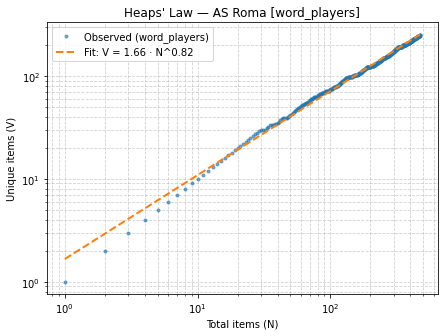

AS Roma [word_players]: K = 1.66, β = 0.82


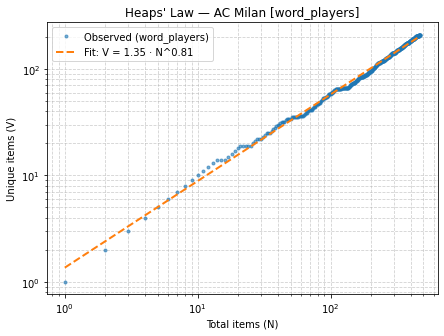

AC Milan [word_players]: K = 1.35, β = 0.81


(1.3545346443936475, 0.8145712324592284)

In [12]:
def plot_heaps_law_on_col(team_df, col="word_players", team_label="Team"):
    """
    Calcola e plotta la Heaps' Law considerando ogni riga della colonna `col`
    come una 'parola' (token). Esempi validi per `col`: "words", "word_players".
    """
    # Prendi i "token" (una stringa per riga), rimuovi NaN e normalizza a str
    tokens = team_df[col].dropna().astype(str).tolist()
    if not tokens:
        raise ValueError(f"Nessun token nella colonna '{col}'")

    total_words, unique_words = [], []
    seen = set()

    for i, tok in enumerate(tokens, start=1):
        seen.add(tok)
        total_words.append(i)              # N
        unique_words.append(len(seen))     # V

    total_words = np.array(total_words, dtype=float)
    unique_words = np.array(unique_words, dtype=float)

    # Evita log(0): scarta eventuali punti con V=0 (di solito non ce ne sono)
    mask = unique_words > 0
    N = total_words[mask]
    V = unique_words[mask]

    # --- Fit Heaps' Law: log(V) = log(K) + β log(N)
    logN = np.log(N)
    logV = np.log(V)
    beta, logK = np.polyfit(logN, logV, 1)
    K = np.exp(logK)

    # Predizione
    V_pred = K * N**beta

    # --- Plot ---
    plt.figure(figsize=(7, 5))
    plt.loglog(N, V, ".", alpha=0.6, label=f"Observed ({col})")
    plt.loglog(N, V_pred, "--", lw=2, label=f"Fit: V = {K:.2f} · N^{beta:.2f}")
    plt.xlabel("Total items (N)")
    plt.ylabel("Unique items (V)")
    plt.title(f"Heaps' Law — {team_label} [{col}]")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.show()

    print(f"{team_label} [{col}]: K = {K:.2f}, β = {beta:.2f}")
    return K, beta

# 🔹 Esempi di utilizzo
# Sulle sequenze di giocatori:
plot_heaps_law_on_col(team1_df, col="word_players", team_label=team1_df.iloc[0]["team_name"])
plot_heaps_law_on_col(team2_df, col="word_players", team_label=team2_df.iloc[0]["team_name"])

In [14]:
path = r"C:\Users\Utente\Desktop\Pasolini and Soccer\La_Liga_24_25_chapters\Barcelona.csv"
df = pd.read_csv(path)

# === 2️⃣ Conta la frequenza di ciascuna combinazione (words + word_players) ===
freq_df = (
    df.groupby(["words", "word_players"])
      .size()                              # conta quante volte appare la coppia
      .reset_index(name="frequency")       # rinomina la colonna conteggio
      .sort_values("frequency", ascending=False)
      .reset_index(drop=True)
)

freq_df.head(30)

,words,word_players,frequency
0,Pressure,Pedro González López,529
1,Pressure,Lamine Yamal Nasraoui Ebana,352
2,Pressure,Raphael Dias Belloli,338
3,Pressure,Robert Lewandowski,290
4,Pressure,Jules Koundé,274
5,Pressure,Marc Casadó Torras,253
6,Pressure,Pablo Martín Páez Gavira,229
7,Pressure,Fermin Lopez Marin,203
8,Pressure,Alejandro Balde Martínez,201
9,Pressure,Eric García Martret,165


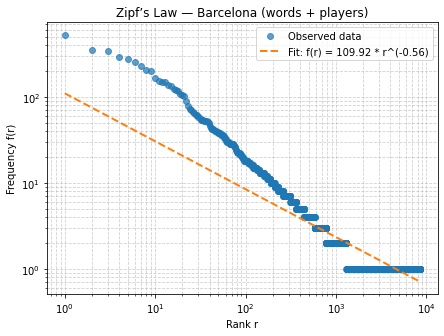

Zipf’s Law fit → α = 0.56, C = 109.92


In [15]:
# === 1️⃣ Ottieni le frequenze ordinate ===
freqs = freq_df["frequency"].values
ranks = np.arange(1, len(freqs) + 1)

# === 2️⃣ Plot log-log ===
plt.figure(figsize=(7, 5))
plt.loglog(ranks, freqs, "o", alpha=0.7, label="Observed data")
plt.xlabel("Rank r")
plt.ylabel("Frequency f(r)")
plt.title("Zipf’s Law — Barcelona (words + players)")
plt.grid(True, which="both", ls="--", alpha=0.6)

# === 3️⃣ Fit lineare nel log-log ===
log_r = np.log(ranks)
log_f = np.log(freqs)
alpha, logC = np.polyfit(log_r, log_f, 1)  # slope = -alpha
alpha = -alpha
C = np.exp(logC)

# Linea teorica
f_pred = C * ranks**(-alpha)
plt.loglog(ranks, f_pred, "--", lw=2, label=f"Fit: f(r) = {C:.2f} * r^(-{alpha:.2f})")
plt.legend()
plt.show()

print(f"Zipf’s Law fit → α = {alpha:.2f}, C = {C:.2f}")

## zipf's Law on players

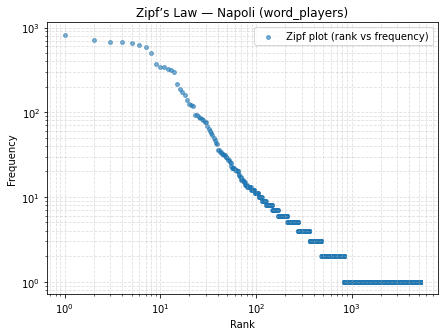

In [18]:
# ---------- Config ----------
PATH = r"Serie_A_24_25_chapters/Napoli.csv"
COLUMN = "word_players"

# ---------- Load data ----------
df = pd.read_csv(PATH)
if COLUMN not in df.columns:
    raise ValueError(f"Column '{COLUMN}' not found in CSV!")

tokens = df[COLUMN].dropna().astype(str).tolist()

# ---------- Frequency count ----------
counts = Counter(tokens)
freqs = np.array(sorted(counts.values(), reverse=True))

# ---------- Compute rank ----------
ranks = np.arange(1, len(freqs) + 1)

# ---------- Log-binning (frequency histogram of frequencies) ----------
bins = np.logspace(np.log10(freqs.min()), np.log10(freqs.max()), num=30)
hist, bin_edges = np.histogram(freqs, bins=bins)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])  # geometric mean

# ---------- Plot (log-log) ----------
plt.figure(figsize=(7, 5))
plt.scatter(ranks, freqs, s=15, alpha=0.6, color="tab:blue", label="Zipf plot (rank vs frequency)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf’s Law — Napoli (word_players)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

plt.show()

In [24]:
# ---------- Config ----------
PATH = r"Serie_A_24_25_chapters/Napoli.csv"
COLUMN = "word_players"

# ---------- Load data ----------
df = pd.read_csv(PATH)
if COLUMN not in df.columns:
    raise ValueError(f"Column '{COLUMN}' not found in CSV!")

tokens = df[COLUMN].dropna().astype(str).tolist()

# ---------- Frequency count ----------
counts = Counter(tokens)

# ---------- Top 20 ----------
top_20 = counts.most_common(50)

# ---------- Display ----------
print("=== Top 50 most frequent 'word_players' ===")
for rank, (token, freq) in enumerate(top_20, start=1):
    print(f"{rank:2d}. {token:30s} {freq}")

=== Top 50 most frequent 'word_players' ===
 1. André-Frank Zambo Anguissa     826
 2. Giovanni Di Lorenzo            712
 3. Amir Rrahmani                  675
 4. Mathías Olivera Miramontes     669
 5. Scott McTominay                655
 6. Matteo Politano                620
 7. Stanislav Lobotka              589
 8. Romelu Lukaku Menama           504
 9. Alessandro Buongiorno          369
10. Khvicha Kvaratskhelia          343
11. David Neres Campos             340
12. Leonardo Spinazzola            328
13. Giacomo Raspadori              311
14. Billy Gilmour                  297
15. Juan Guilherme Nunes Jesus     215
16. Giovanni Pablo Simeone         190
17. Scott McTominay-Scott McTominay 171
18. André-Frank Zambo Anguissa-André-Frank Zambo Anguissa 161
19. Pasquale Mazzocchi             138
20. Romelu Lukaku Menama-Romelu Lukaku Menama 125
21. Alex Meret                     123
22. Matteo Politano-Matteo Politano 118
23. Mathías Olivera Miramontes-Mathías Olivera Miramontes 94
2

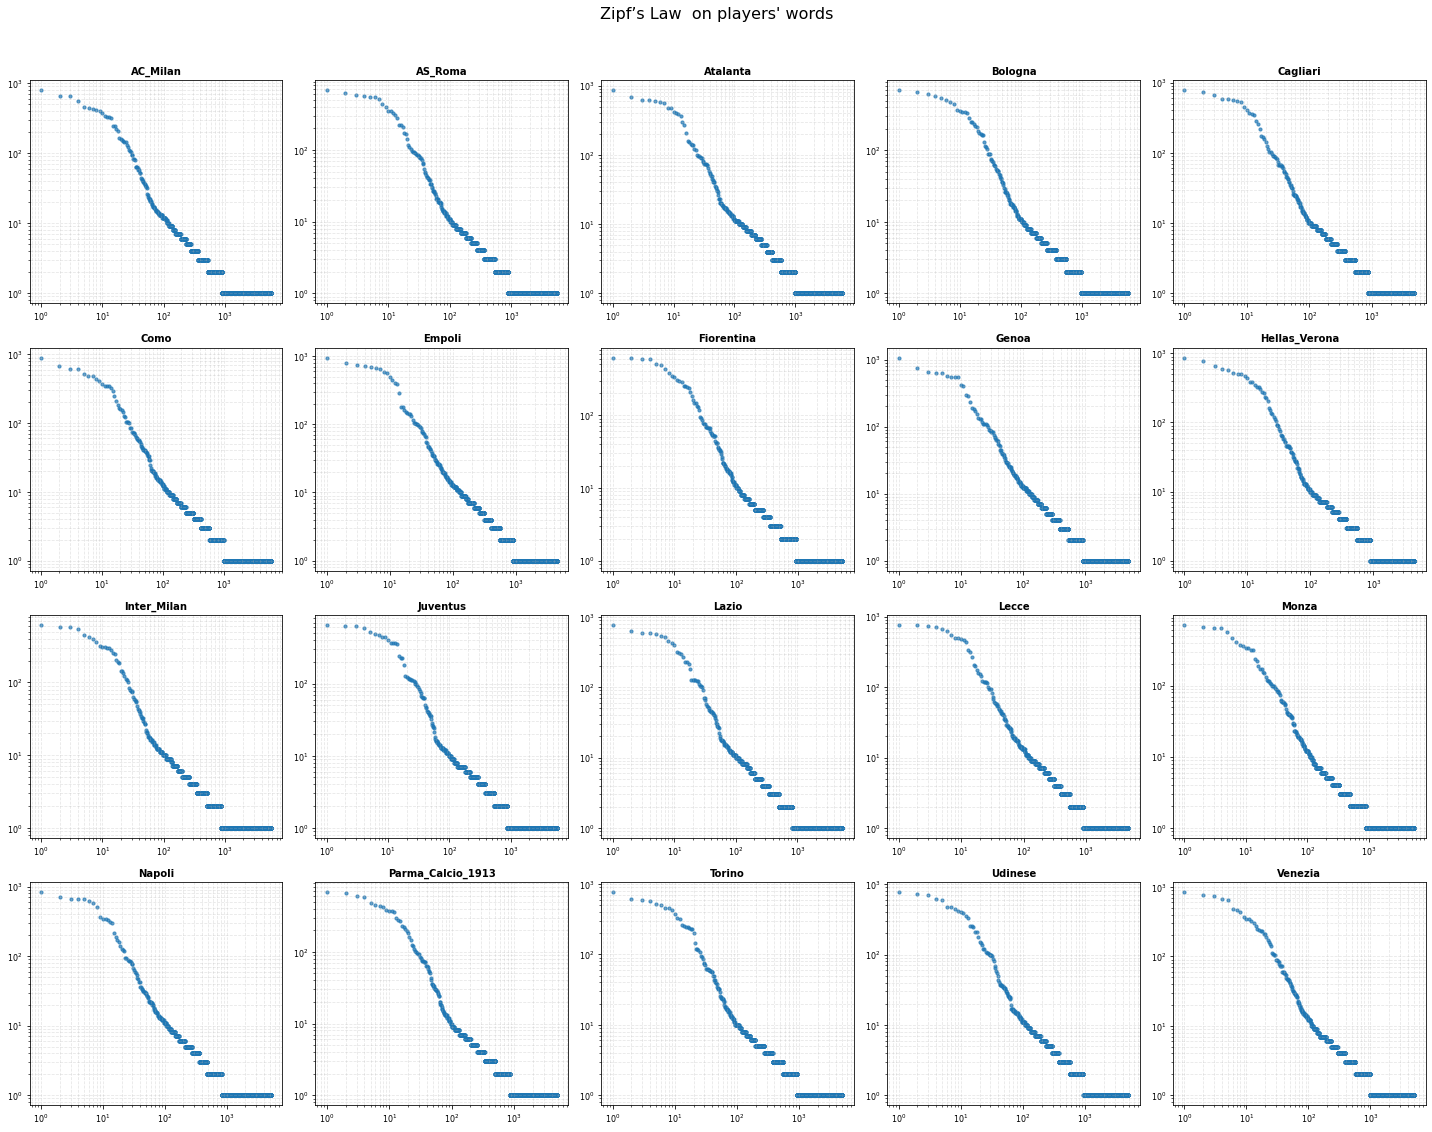

In [23]:
# ---------- Config ----------
INPUT_DIR = r"Serie_A_24_25_chapters"
COLUMN = "word_players"
FILES = [
    f for f in sorted(os.listdir(INPUT_DIR))
    if f.endswith(".csv") and f != "Serie_A_24_25.csv"
]

# ---------- Check number of teams ----------
if len(FILES) != 20:
    print(f"⚠️ Warning: expected 20 teams, found {len(FILES)} files")

# ---------- Setup subplot 4x5 ----------
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

# ---------- Iterate through each team file ----------
for i, file in enumerate(FILES):
    path = os.path.join(INPUT_DIR, file)
    try:
        df = pd.read_csv(path, usecols=[COLUMN])
        tokens = df[COLUMN].dropna().astype(str).tolist()

        if not tokens:
            continue

        counts = Counter(tokens)
        freqs = np.array(sorted(counts.values(), reverse=True))
        ranks = np.arange(1, len(freqs) + 1)

        # --- log-log Zipf plot ---
        axes[i].scatter(
            ranks, freqs, s=10, alpha=0.7, color="tab:blue"
        )
        axes[i].set_xscale("log")
        axes[i].set_yscale("log")

        # --- formatting ---
        team_name = os.path.splitext(file)[0]
        axes[i].set_title(team_name, fontsize=10, fontweight="bold")
        axes[i].grid(True, which="both", linestyle="--", alpha=0.3)
        axes[i].tick_params(axis="both", which="major", labelsize=8)

    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

# ---------- Hide unused subplots if any ----------
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Zipf’s Law  on players' words", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()